# Mentor-Mentee Recommendation System

In this project I will build a recommendation system that matches mentees with mentors based on text. 

The dataset used for this is the public DBLP dataset. 

## Preparations

#### Packages

In [1]:
import os

import xml.sax
import re
import csv

import random

#topic extraction
from rake_nltk import Rake


#and the usual suspects:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Importing the Data

Setting the working directory:

In [2]:
os.chdir("C:/Users/IBM_Admin/Desktop/PMI")

Importing the data as xml file and creating two txt files:

In [ ]:
class DBLPContentHandler(xml.sax.ContentHandler):
  """
  Reads the dblp.xml file and produces two output files.
        pubFile.txt = (key, pubtype) tuples
        fieldFile.txt = (key, fieldCnt, field, value) tuples
  Each file is tab-separated
  """

  def __init__(self):
    xml.sax.ContentHandler.__init__(self) #initializing the new class


  def startElement(self, name, attrs):
    if name == "dblp":
      DBLPContentHandler.pubFile = open('pubFile.txt', 'w')
      DBLPContentHandler.fieldFile = open('fieldFile.txt', 'w')
      DBLPContentHandler.pubList = ["article", "inproceedings", "proceedings", "book", "incollection", 
                                    "phdthesis", "mastersthesis", "www"]
      DBLPContentHandler.fieldList = ["author", "editor", "title", "booktitle", "pages", "year", "address", 
                                      "journal", "volume", "number", "month", "url", "ee", "cdrom", "cite", 
                                      "publisher", "note", "crossref", "isbn", "series", "school", "chapter"]
      DBLPContentHandler.content = ""
    if name in DBLPContentHandler.pubList:
      DBLPContentHandler.key = attrs.getValue("key")
      DBLPContentHandler.pub = name
      DBLPContentHandler.fieldCount = 0b
      DBLPContentHandler.content = ""
    if name in DBLPContentHandler.fieldList:
      DBLPContentHandler.field = name
      DBLPContentHandler.content = ""
 
  def endElement(self, name):
    if name in DBLPContentHandler.fieldList:
      DBLPContentHandler.fieldFile.write(DBLPContentHandler.key)
      DBLPContentHandler.fieldFile.write("\t")
      DBLPContentHandler.fieldFile.write(str(DBLPContentHandler.fieldCount))
      DBLPContentHandler.fieldFile.write( "\t")
      DBLPContentHandler.fieldFile.write(DBLPContentHandler.field)
      DBLPContentHandler.fieldFile.write("\t")
      DBLPContentHandler.fieldFile.write(DBLPContentHandler.content)
      DBLPContentHandler.fieldFile.write("\n")
      DBLPContentHandler.fieldCount += 1
    if name in DBLPContentHandler.pubList:
      DBLPContentHandler.pubFile.write(DBLPContentHandler.key)
      DBLPContentHandler.pubFile.write("\t")
      DBLPContentHandler.pubFile.write(DBLPContentHandler.pub)
      DBLPContentHandler.pubFile.write("\n")

  def characters(self, content):
    DBLPContentHandler.content += content.encode('utf-8').replace('\\','\\\\')

def main(sourceFileName):
  source = open(sourceFileName)
  xml.sax.parse(source, DBLPContentHandler())
 
if __name__ == "__main__":
    main("C:/Users/IBM_Admin/Desktop/PMI/dblp.xml")

### Setting up indexes and column names

Opening the resulting txt files:

In [3]:
Field = pd.read_table("fieldFile.txt",header=None,index_col=[0])
Pub = pd.read_table("pubFile.txt", header = None, index_col=[0])

In [4]:
Field.columns = ["number" , "attribute", "value"]
Field.index.names=["key"]
Field.head()

,number,attribute,value
key,,,
journals/acta/Saxena96,0,author,Sanjeev Saxena
journals/acta/Saxena96,1,title,Parallel Integer Sorting and Simulation Amongs...
journals/acta/Saxena96,2,pages,607-619
journals/acta/Saxena96,3,year,1996
journals/acta/Saxena96,4,volume,33


In [5]:
Pub.columns = ["type"]
Pub.index.names=["key"]
Pub.head()

,type
key,
journals/acta/Saxena96,article
journals/acta/Simon83,article
journals/acta/GoodmanS83,article
journals/acta/Blum82,article
journals/acta/Schonhage77,article


Before I do anything else I'm going to calculate how many co-authors every article has. I'm planning to merge this back to an author-level dataset, so I'm substracting 1 as authors have not worked with themselves.

In [6]:
authorcount = pd.DataFrame(Field.loc[Field["attribute"]=="author"].iloc[:,2])
authorcount = authorcount.groupby('key').agg('count')
authorcount.columns = ["number of co-authors"]
authorcount["number of co-authors"] = pd.to_numeric(authorcount["number of co-authors"]) -1 #remove self
authorcount.head()

## number of unique co-authors?

,number of co-authors
key,
books/acm/0082477,0
books/acm/kim95/AnnevelinkACFHK95,5
books/acm/kim95/Blakeley95,0
books/acm/kim95/BreitbartGS95,2
books/acm/kim95/BreitbartR95,1


Merge Pub with authorcount

In [7]:
Pub = Pub.join(authorcount)
Pub.head()

,type,number of co-authors
key,,
journals/acta/Saxena96,article,0.0
journals/acta/Simon83,article,0.0
journals/acta/GoodmanS83,article,1.0
journals/acta/Blum82,article,0.0
journals/acta/Schonhage77,article,0.0


### Random Selection

Since this is a prototype we don't need all the data. A subsample of 500 authors should be more than enough to build a working system. 

In [8]:
## Set seed
random.seed(9999)

In [9]:
authornames = pd.DataFrame(Field.loc[Field["attribute"]=="author"].iloc[:,2])
randomauthors = random.sample(authornames.iloc[:,0].unique(),500)

In [10]:
publications = Field[Field.value.isin(randomauthors)] #take all the rows with the authors in it
df = Field[Field.index.isin(publications.index)] #take all the publications to get the right information

In [11]:
df.head()

,number,attribute,value
key,,,
journals/cii/Hernandez-Rodriguez16,0,author,Selene Hernández-Rodríguez
journals/cii/Hernandez-Rodriguez16,1,author,Carlos Alberto Hernández-Lira
journals/cii/Hernandez-Rodriguez16,2,author,Adolfo Aguilar-Rico
journals/cii/Hernandez-Rodriguez16,3,author,Georgina Flores Becerra
journals/cii/Hernandez-Rodriguez16,4,author,Javier Flores-Méndez


## Data Preparations

I will need one row per author + key in the end. As an author can have multiple topics they're publishing in, I can't create one line per author. 

In [12]:
authors = pd.DataFrame(df.loc[df["attribute"]=="author"].iloc[:,2])
authors.columns=["author"]

In [13]:
df2 = df.pivot_table(index="key",columns="attribute",values="value",aggfunc=max)
df2 = df2.drop('author',axis=1)

In [14]:
df2 = df2.join(Pub)

Merging authors with df2 should give a dataset with one row per author+key

In [15]:
full = authors.join(df2).drop(['cite','crossref','ee','isbn','url', 'cdrom','editor','journal',
                              'note','number','pages','publisher','school','series','volume','type'],axis=1) #dropping variables I don't need
full.head() #now for every author I have the attributes I'll need

,author,booktitle,title,year,number of co-authors
key,,,,,
books/bc/tanselCGSS93/Gadia93,Shashi K. Gadia,Temporal Databases,Ben-Zvi's Pioneering Work in Relational Tempor...,1993,0.0
books/bc/tanselCGSS93/GadiaN93,Shashi K. Gadia,Temporal Databases,Temporal Databases: A Prelude to Parametric Data.,1993,1.0
books/bc/tanselCGSS93/GadiaN93,Sunil S. Nair,Temporal Databases,Temporal Databases: A Prelude to Parametric Data.,1993,1.0
books/crc/IIR2005/CesarioWJ05,Wander O. Cesário,The Industrial Information Technology Handbook,Hardware/Software Interfaces Design for SoC.,2005,2.0
books/crc/IIR2005/CesarioWJ05,Flávio Rech Wagner,The Industrial Information Technology Handbook,Hardware/Software Interfaces Design for SoC.,2005,2.0


In [16]:
#remove the authors not in random authors as most likely part of their work is missing and therefore it 
# wouldn't be fair to use them
full = full[full.author.isin(randomauthors)]

### Missing Values

It could be that the author is missing. Since they represent the mentors it doesn't make sense to have them in there if there's no name.

In [18]:
full = full.dropna(axis=0, how='any', subset=['author'])

## Feature Engineering

#### Set Column Types

In [17]:
full['year'] = full['year'].apply(pd.to_numeric)

#### Number of Publications (Expertise)

In [19]:
author_articles = pd.DataFrame(full.groupby('author').nunique().loc[:,'title'])
author_articles.columns = ["number of publications"]

#### Years of Activity (Experience)

In [20]:
minyear = pd.DataFrame(full.groupby('author').agg('min').iloc[:,2])
minyear.columns=["year_min"]
maxyear = pd.DataFrame(full.groupby('author').agg('max').iloc[:,2])
maxyear.columns=["year_max"]
years = minyear.join(maxyear)

In [21]:
years = years.replace(np.inf,np.nan)
years.year_min.fillna(years.year_max,inplace=True)
years['years_active']=pd.to_numeric(years['year_max'])-pd.to_numeric(years['year_min'])+1

#### Number of Co-Authors (Social)

In [22]:
co_min = pd.DataFrame(full.groupby('author').agg('min').loc[:,'number of co-authors'])
co_min.columns=["co_min"]
co_max = pd.DataFrame(full.groupby('author').agg('max').loc[:,'number of co-authors'])
co_max.columns=["co_max"]
co_mean = pd.DataFrame(full.groupby('author').agg('mean').loc[:,'number of co-authors'])
co_mean.columns=["co_mean"]

In [23]:
co = co_min.join(co_max)
co = co.join(co_mean)
co.head()

,co_min,co_max,co_mean
author,,,
A. Sailer,0.0,4.0,2.0
A. Zhuravlev,0.0,4.0,2.0
Abalfazl Zareei,0.0,4.0,2.0
Abdelkader Benabou,0.0,3.0,1.5
Abel Bueno,0.0,3.0,1.5


#### Merge all of it

In [24]:
author_information = author_articles.join(years)
author_information = author_information.join(co)

In [25]:
author_information.head()

,number of publications,year_min,year_max,years_active,co_min,co_max,co_mean
author,,,,,,,
A. Sailer,2,2016.0,2016.0,1.0,0.0,4.0,2.0
A. Zhuravlev,2,2015.0,2015.0,1.0,0.0,4.0,2.0
Abalfazl Zareei,2,2011.0,2011.0,1.0,0.0,4.0,2.0
Abdelkader Benabou,2,2014.0,2014.0,1.0,0.0,3.0,1.5
Abel Bueno,2,2005.0,2005.0,1.0,0.0,3.0,1.5


#### Merge back with full dataset

In [26]:
full = full.join(author_information,'author')
full = full.drop(['year','number of co-authors','year_min','year_max','co_min','co_max'],axis=1)
full.head()

,author,booktitle,title,number of publications,years_active,co_mean
key,,,,,,
books/bc/tanselCGSS93/Gadia93,Shashi K. Gadia,Temporal Databases,Ben-Zvi's Pioneering Work in Relational Tempor...,46,32.0,2.065217
books/bc/tanselCGSS93/GadiaN93,Shashi K. Gadia,Temporal Databases,Temporal Databases: A Prelude to Parametric Data.,46,32.0,2.065217
books/crc/IIR2005/CesarioWJ05,Wander O. Cesário,The Industrial Information Technology Handbook,Hardware/Software Interfaces Design for SoC.,26,11.0,3.592593
books/crc/linked14/ParundekarKA14,Rahul Parundekar,Linked Data Management,Aligning Ontologies of Linked Data.,11,6.0,1.833333
books/crc/zurawski2009/PopoviciCWJ09,Wander O. Cesário,Embedded Systems Design and Verification,Hardware/Software Interfaces Design for SoC.,26,11.0,3.592593


### Text Mining: Topic Extraction

For topic extraction I use the RAKE algorithm for keyword extraction.

In [66]:
r=Rake()
mytext = full.iloc[:,2]
mytext = mytext.str.strip()

In [67]:
for i in range(0,mytext.size):
    mytext[i] = mytext[i].decode('utf-8')

In [68]:
topic_features = [None] * mytext.size
for i in range(0,mytext.size):
    r.extract_keywords_from_text(mytext[i])
    topic_features[i] = r.get_ranked_phrases()[0:2]

In [69]:
full["topic features"] = topic_features
full.columns=["Mentor","booktitle","title","Expertise","Experience","Social","topic features"]

In [70]:
full.head()

,Mentor,booktitle,title,Expertise,Experience,Social,topic features
key,,,,,,,
books/bc/tanselCGSS93/Gadia93,Shashi K. Gadia,Temporal Databases,Ben-Zvi's Pioneering Work in Relational Tempor...,46,32.0,2.065217,"[relational temporal databases, pioneering work]"
books/bc/tanselCGSS93/GadiaN93,Shashi K. Gadia,Temporal Databases,Temporal Databases: A Prelude to Parametric Data.,46,32.0,2.065217,"[temporal databases, parametric data]"
books/crc/IIR2005/CesarioWJ05,Wander O. Cesário,The Industrial Information Technology Handbook,Hardware/Software Interfaces Design for SoC.,26,11.0,3.592593,"[software interfaces design, soc]"
books/crc/linked14/ParundekarKA14,Rahul Parundekar,Linked Data Management,Aligning Ontologies of Linked Data.,11,6.0,1.833333,"[linked data, aligning ontologies]"
books/crc/zurawski2009/PopoviciCWJ09,Wander O. Cesário,Embedded Systems Design and Verification,Hardware/Software Interfaces Design for SoC.,26,11.0,3.592593,"[software interfaces design, soc]"


Note:
I would have liked to have done the following: 
 - per author combine all the keyword phrases
 - Run Bag of Words on this combined collection to see if that can help find the most important/frequent topics

## Recommendation System

Mentee asks for a specific topic

In [32]:
topic = raw_input("Please choose a topic: ")

Please choose a topic: Databases


In [33]:
#topic = topic.str.lower()
mentors = full[full.title.str.lower().str.contains(topic.lower())]['Mentor'].unique()

possible_mentors = full[full['Mentor'].isin(mentors)].groupby('Mentor').agg('max').drop(['booktitle','title'],axis=1)

In [34]:
values = raw_input("Which do you value the most? Expertise, Experience, Social: ")

Which do you value the most? Expertise, Experience, Social: Social


In [35]:
print "Your possible mentors are, sorted by ", values, ":"

Your possible mentors are, sorted by  Social :


In [36]:
possible_mentors = possible_mentors.sort_values(values,ascending=False)
possible_mentors

,Expertise,Experience,Social,topic features
Mentor,,,,
Ismael Navas Delgado,52,14.0,3.509434,"[visual semantic browser, vsb]"
Arvind Narayanan,52,15.0,2.826923,"[wireless testbed using geni, robotic mobile n..."
Justin Pearson,68,20.0,2.657143,"[workload constraints arising, violation funct..."
Kevin Watanabe,2,1.0,2.500000,"[molecular biology databases, metabolic pathwa..."
Shashi K. Gadia,46,32.0,2.065217,"[zero information loss, relational database sy..."
John Kominek,19,17.0,1.578947,"[word selection strategies, learning pronuncia..."
Azade Roohany,2,1.0,0.500000,"[proposing cluster_similarity method, much bet..."
Walid Adly Atteya Abdo,2,1.0,0.000000,[home page]


In [37]:
print "Mentor Match's best suggestion would be:", possible_mentors.index[0]

Mentor Match's best suggestion would be: Ismael Navas Delgado


## Plots

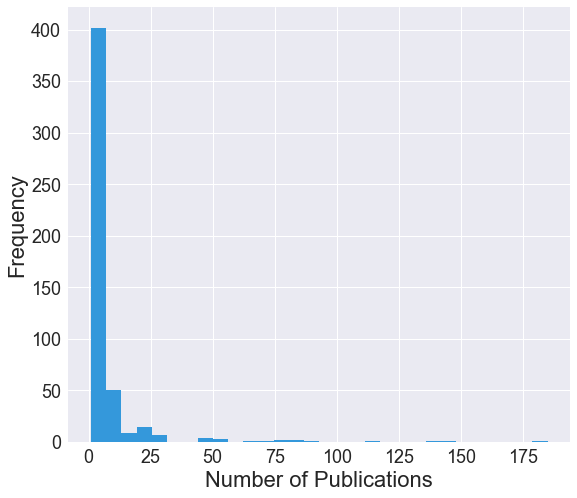

In [50]:
# Publications
plt.figure(figsize=(9, 8))
plt.hist(full.groupby('Mentor').agg('min').iloc[:,2].dropna(),bins=30,color="#3498db")
plt.ylabel("Frequency",fontsize=22)
plt.xlabel("Number of Publications",fontsize=22)
plt.tick_params(labelsize=18)

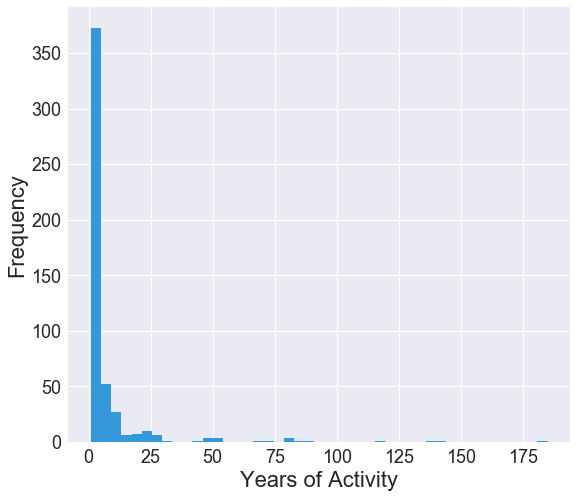

In [51]:
# years active
plt.figure(figsize=(9, 8))
plt.hist(full.groupby('Mentor').agg('min').iloc[:,2].dropna(),bins=45,color="#3498db")
plt.ylabel("Frequency",fontsize=22)
plt.xlabel("Years of Activity",fontsize=22)
plt.tick_params(labelsize=18)

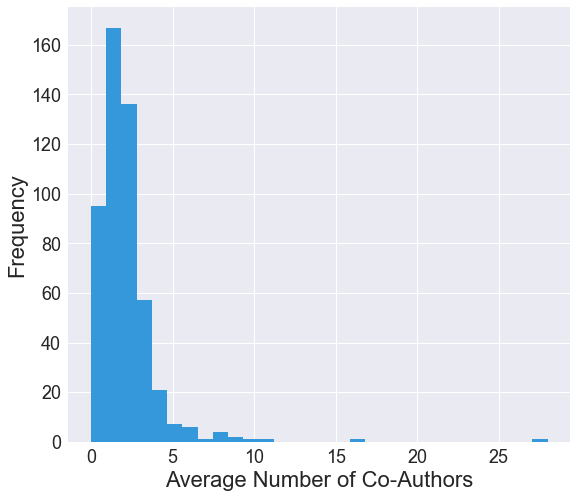

In [54]:
# mean co-authors
plt.figure(figsize=(9, 8))
plt.hist(full.groupby('Mentor').agg('min').iloc[:,4].dropna(),bins=30,color="#3498db")
plt.ylabel("Frequency",fontsize=22)
plt.xlabel("Average Number of Co-Authors",fontsize=22)
plt.tick_params(labelsize=18)

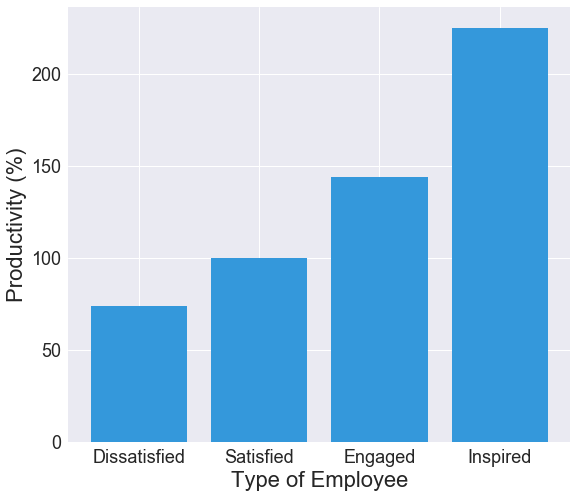

In [53]:
plt.figure(figsize=(9, 8))
Employee = ["Dissatisfied","Satisfied","Engaged","Inspired"]
values = [74, 100, 144, 225]
plt.bar(range(len(Employee)),values,align='center',color="#3498db")
plt.xticks(range(len(Employee)),Employee)
plt.ylabel("Productivity (%)",fontsize=22)
plt.xlabel("Type of Employee",fontsize=22)
plt.tick_params(labelsize=18)